In [16]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import joblib
import itertools
import random

# seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# -------------------------------
# Step 1: Load Data and Artifacts
# -------------------------------
X_train_df = pd.read_csv("data_withoutembeddings/X_train.csv")
y_train_df = pd.read_csv("data_withoutembeddings/y_train.csv")

scaler = joblib.load("data_withoutembeddings/standard_scaler.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# -------------------------------
# Step 2: Define Feature Lists
# -------------------------------
numeric_features = list(X_train_df.columns)

# -------------------------------
# Step 3: Filter Data for Fraud Cases and Non-Fraud Cases
# -------------------------------
y_train = y_train_df.iloc[:, 0]
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

X_train_num = X_train_df[numeric_features].loc[fraud_mask].values
X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

# -------------------------------
# Step 4: Engineered Features (time features)
# -------------------------------
eng_features = ['hour', 'day', 'month', 'weekday', 'distance']
eng_indices = [numeric_features.index(feat) for feat in eng_features]

eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
eng_min = torch.tensor(eng_min_np, dtype=torch.float32)
eng_max = torch.tensor(eng_max_np, dtype=torch.float32)
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# -------------------------------
# Step 5: Create Dataset and DataLoader
# -------------------------------
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data):
        self.data = torch.tensor(num_data, dtype=torch.float32)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num)
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)

# -------------------------------
# Step 6: Set Device and Diffusion Hyperparameters
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0).to(device)

# Compute non-fraud statistics for prior loss
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

# Loss weight parameters
w1 = 0.2
w2 = 0.6

# -------------------------------
# Step 7: Define Loss Functions and Forward Diffusion
# -------------------------------
def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# -------------------------------
# Step 8: Define the Model (CombinedNoisePredictor)
# -------------------------------
class CombinedNoisePredictor(nn.Module):
    def __init__(self,input_dim, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)  # +1 for timestep
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.LeakyReLU()
        
    def forward(self, x, t):
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817  -2.58862707] max: [1.49563575 1.70671805 1.41547433 1.37969415 2.31907895]
Using device: cpu


In [17]:
best_config = {'lr': 0.001, 'hidden_dim': 256, 'cat_embed_dim': 8, 'lambda_eng': 0.05}

In [18]:
print("Training final model with best configuration:", best_config)

# Instantiate the final model using the best hyperparameters
final_model = CombinedNoisePredictor(
    input_dim=len(numeric_features),
    hidden_dim=best_config['hidden_dim']
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_config['lr'])

# Define the number of epochs for final training (e.g., 250 epochs)
final_epochs = 250

for epoch in range(final_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0 = batch.to(device)  # Now x0 is the combined numeric input
        batch_size = x0.shape[0]
        
        # Sample random timesteps for diffusion:
        t = torch.randint(0, T_train, (batch_size,), device=device)
        x_t, true_noise = forward_diffusion(x0, t)
        pred_noise = final_model(x_t, t)
        # pred_noise should be of shape [batch, input_dim]
        
        L_norm = compute_Lnorm(pred_noise, true_noise)
        L_prior = compute_Lprior(pred_noise)
        
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est = (x_t - sqrt_one_minus_alpha_hat_t * pred_noise) / sqrt_alpha_hat_t
        
        # For triplet loss, sample negatives from non-fraud data
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0, negative_sample)
        
        # Engineered range loss for engineered features (if applicable)
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min.to(device), eng_max.to(device))
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + best_config['lambda_eng'] * L_eng
        final_optimizer.zero_grad()
        total_loss.backward()
        final_optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch+1}/{final_epochs}], Loss: {avg_loss:.4f}")

# Save final model:
torch.save(final_model.state_dict(), "final_model.pth")
print("Final model trained and saved.")

Training final model with best configuration: {'lr': 0.001, 'hidden_dim': 256, 'cat_embed_dim': 8, 'lambda_eng': 0.05}
Epoch [1/250], Loss: 1827.1861
Epoch [2/250], Loss: 1.4018
Epoch [3/250], Loss: 2.0237
Epoch [4/250], Loss: 1.7606
Epoch [5/250], Loss: 1.6393
Epoch [6/250], Loss: 4.8478
Epoch [7/250], Loss: 2.1304
Epoch [8/250], Loss: 5.8526
Epoch [9/250], Loss: 4.6242
Epoch [10/250], Loss: 1.8750
Epoch [11/250], Loss: 3.0043
Epoch [12/250], Loss: 5.0551
Epoch [13/250], Loss: 3.1171
Epoch [14/250], Loss: 1.6499
Epoch [15/250], Loss: 11.8214
Epoch [16/250], Loss: 8.8393
Epoch [17/250], Loss: 1.4835


KeyboardInterrupt: 

Synthetic numeric samples shape (normalized): torch.Size([100, 12])
Synthetic categorical samples shape: torch.Size([100, 6])
Real Fraud Numeric Statistics (Original Scale):
               amt     city_pop          age          hour          day  \
count  6273.000000  6273.000000  6273.000000  6.273000e+03  6273.000000   
mean      5.553833     8.427249    48.933842  1.396126e+01    15.704448   
std       1.627878     2.443052    18.723719  9.707241e+00     8.773403   
min       0.722706     3.178054    14.000000  3.545246e-08     1.000001   
25%       5.479722     6.679599    33.000000  2.000000e+00     8.000000   
50%       5.958528     7.940228    48.000000  2.200000e+01    15.000000   
75%       6.802939     9.893640    61.000000  2.300000e+01    23.000000   
max       7.227692    14.882529    96.000000  2.300000e+01    31.000000   

             month       weekday     distance          lat         long  \
count  6273.000000  6.273000e+03  6273.000000  6273.000000  6273.000000   


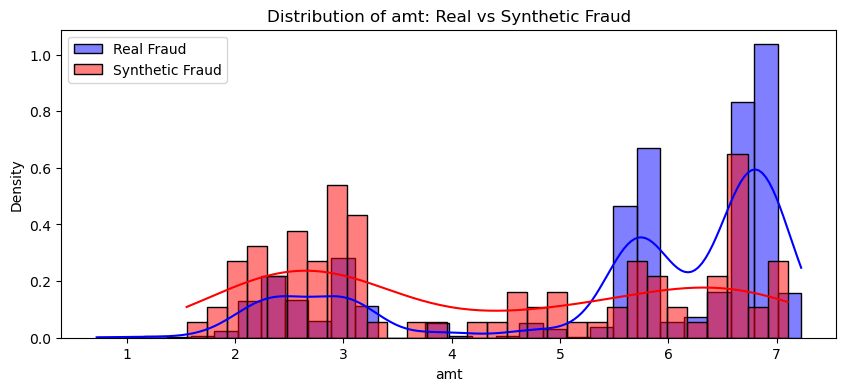

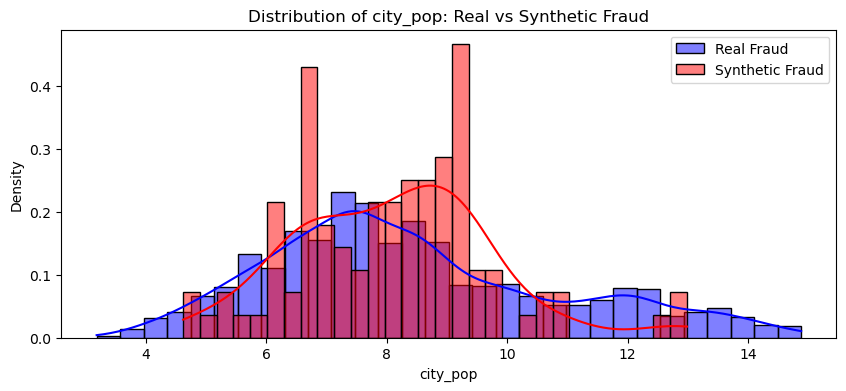

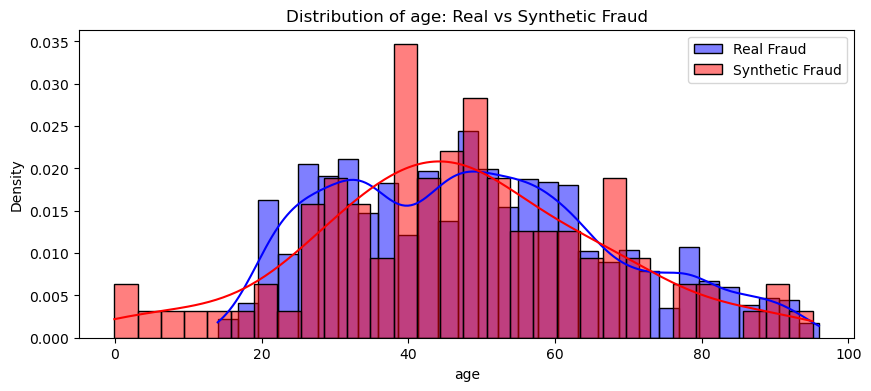

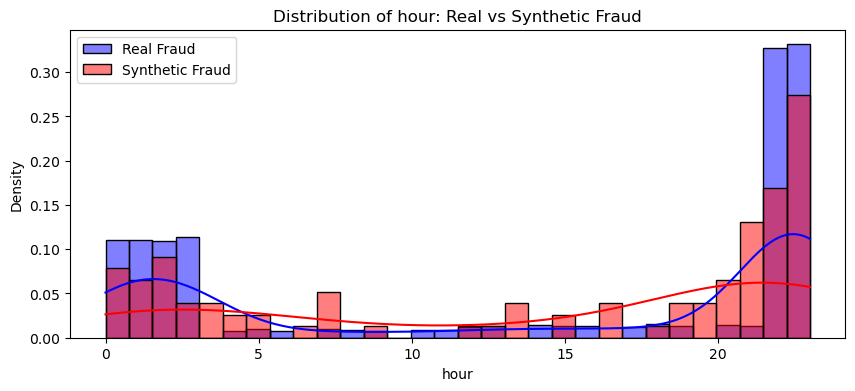

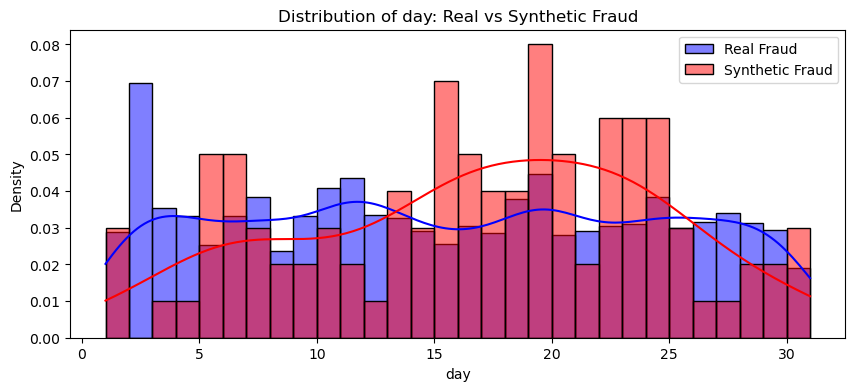

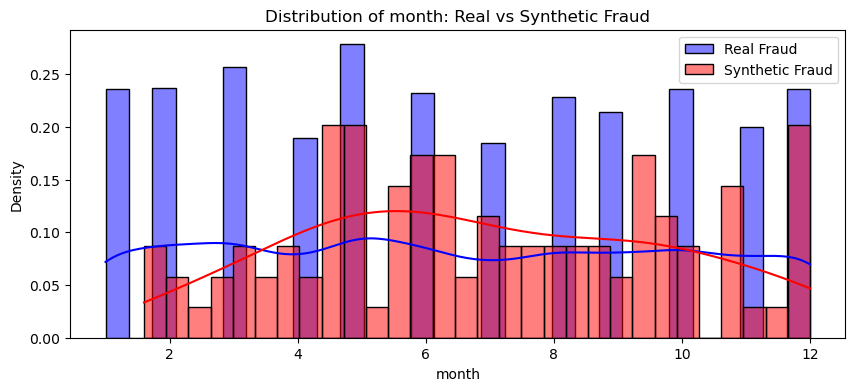

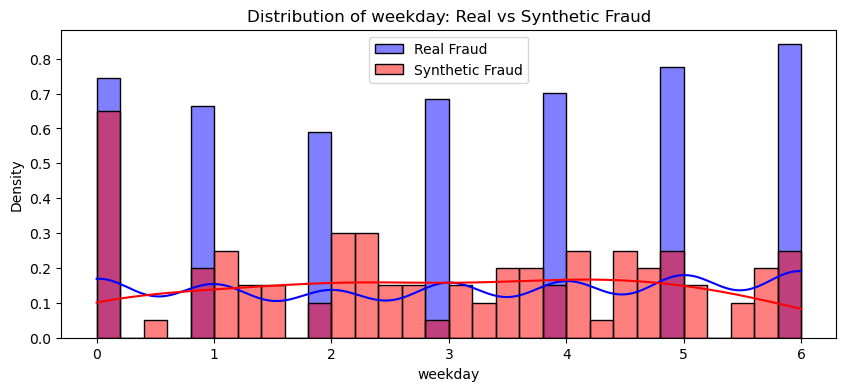

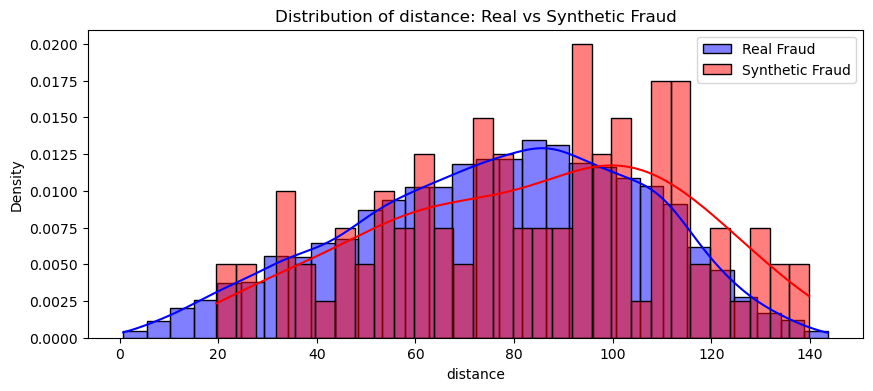

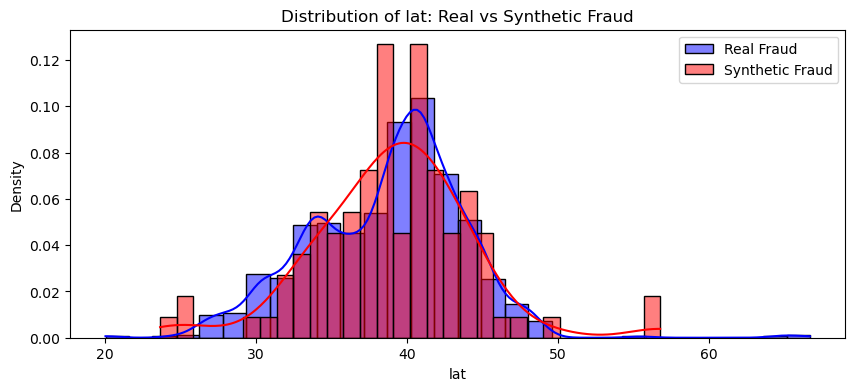

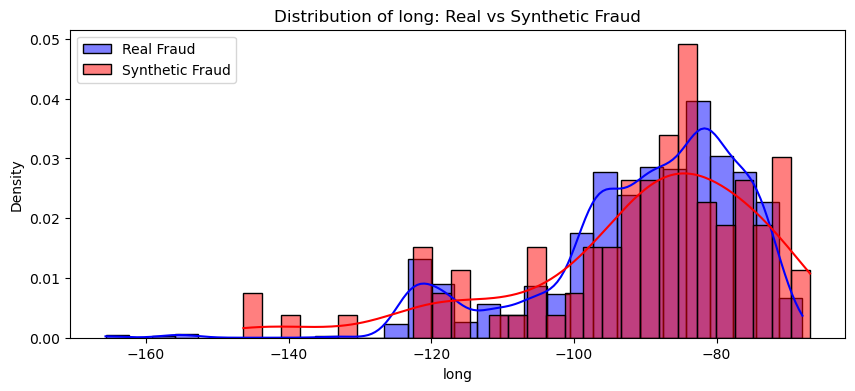

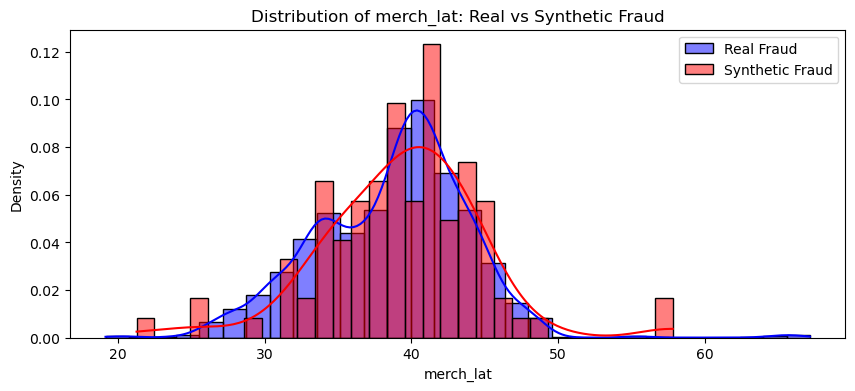

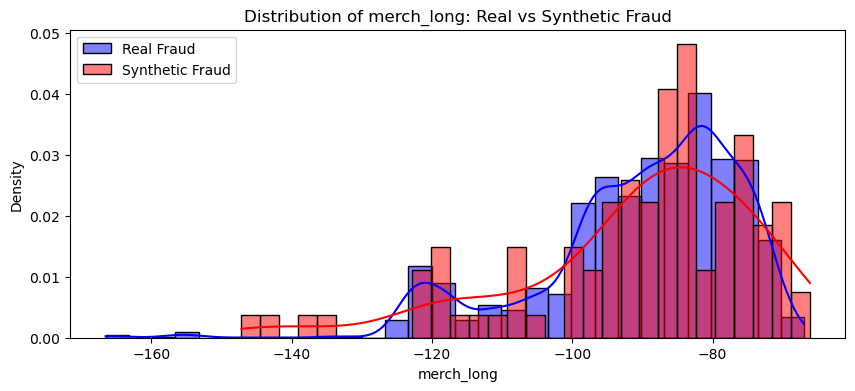

In [ ]:
# -------------------------------
# Step 10: Generate Synthetic Fraud Samples via Reverse Diffusion
# -------------------------------
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    model.eval()
    with torch.no_grad():
        num_input_dim = len(numeric_features)
        # Initialize with statistics from real fraud data.
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        noise = torch.randn(num_samples, num_input_dim).to(device)
        x_t_num = X_fraud_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
                  X_fraud_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process.
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            pred_noise = model(x_t_num, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        
        # Clip engineered features to observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped

num_synthetic = 100
synthetic_num_norm = generate_synthetic_fraud(final_model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)

# -------------------------------
# Step 11: Inverse Transform Numeric Features to Original Scale
# -------------------------------
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

# -------------------------------
# Step 12: Combine and Evaluate Synthetic vs. Real Data
# -------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for synthetic and real fraud data.
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

# Plot distributions for each feature.
for col in numeric_features:
    plt.figure(figsize=(10,4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()